# MIDAS@IITD - CV Problem Statement
> Solution to the CV problem statement as a part of MIDAS@IIITD Summer Internship Task

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as c_m
from sklearn.metrics import accuracy_score as a_s
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


### Reading training data

In [2]:
with open('train_image.pkl', 'rb') as f:
    train = pickle.load(f)

### Reading training data labels

In [3]:
with open('train_label.pkl', 'rb') as f:
    label = pickle.load(f)

### Reading testing data

In [4]:
with open('test_image.pkl', 'rb') as f:
    test = pickle.load(f)

### Setting batch size and image dimension

In [5]:
img_dim=28
batch_size=128

### Converting given datasets to usable form

In [6]:
label = pd.DataFrame(label) #conversion of labels to dataframe

In [7]:
train = np.array(train) #conversion of train to array
test = np.array(test) #conversion of test to array

In [8]:
print(train.shape) #shape of data array
print(test.shape) #shape of test array

(8000, 784)
(2000, 784)


### Setting of dimensions of image
> Since 784 is a square of 28, it was assumed that the frame dimensions are of 28x28

In [9]:
train = np.reshape(train, (train.shape[0], img_dim, img_dim, 1))
test = np.reshape(test, (test.shape[0], img_dim, img_dim, 1))
#reshaping data and test to format (no_of_images, length, width, no_of_channels)

In [10]:
print(train.shape)
print(test.shape)

(8000, 28, 28, 1)
(2000, 28, 28, 1)


### Finding unique labels in the training dataset
> We observe that there are 4 unique labels for the training dataset

In [11]:
label[0].unique()

array([0, 2, 3, 6])

### Count of each label in dataset

[Text(0.5, 0, 'label')]

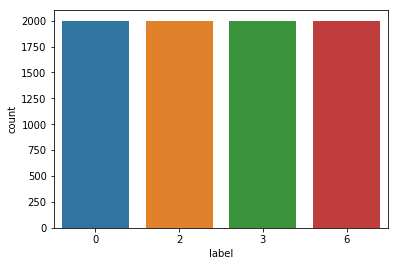

In [12]:
ax = sns.countplot(x=0, data=label)
ax.set(xlabel='label')

### Train Test Split
> Split dataset into train and validation sets with 10% as validation data i.e. 800 images

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(train, label, test_size = 0.1, random_state=123)

### Count of each label in training dataset

[Text(0.5, 0, 'label')]

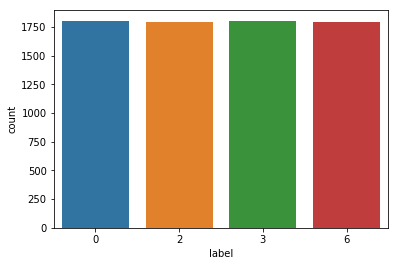

In [14]:
ax = sns.countplot(x=0, data=y_train)
ax.set(xlabel='label')

### Count of each label in validation dataset

[Text(0.5, 0, 'label')]

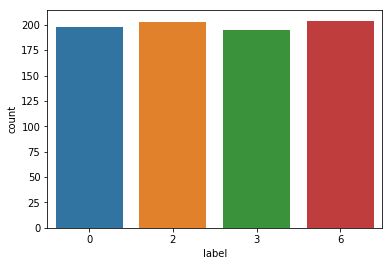

In [15]:
ax = sns.countplot(x=0, data=y_valid)
ax.set(xlabel='label')

In [16]:
y_train = y_train.astype(str) #convert to string type to convert categorical variable
y_train = pd.get_dummies(y_train) #converts categorical variable to indicator variable
print(y_train.shape)

(7200, 4)


In [17]:
y_train.sample(10) #show top 10 labels

,0_0,0_2,0_3,0_6
184,1,0,0,0
2619,0,1,0,0
705,1,0,0,0
99,1,0,0,0
6776,0,0,0,1
666,1,0,0,0
1106,1,0,0,0
1494,1,0,0,0
6818,0,0,0,1
3154,0,1,0,0


In [18]:
y_valid = y_valid.astype(str) #convert to string type to convert categorical variable
y_valid = pd.get_dummies(y_valid) #converts categorical variable to indicator variable
print(y_valid.shape)

(800, 4)


In [19]:
y_valid.sample(10) #show top 10 labels

,0_0,0_2,0_3,0_6
2492,0,1,0,0
7581,0,0,0,1
2085,0,1,0,0
1769,1,0,0,0
276,1,0,0,0
5051,0,0,1,0
1818,1,0,0,0
9,1,0,0,0
7277,0,0,0,1
4371,0,0,1,0


### Plotting the sample images from the training dataset
> From the plots we see that the images are a part of Fashion-MNIST dataset.  
> The labels are of T-shirt, Pullover, Dress and Shirt.

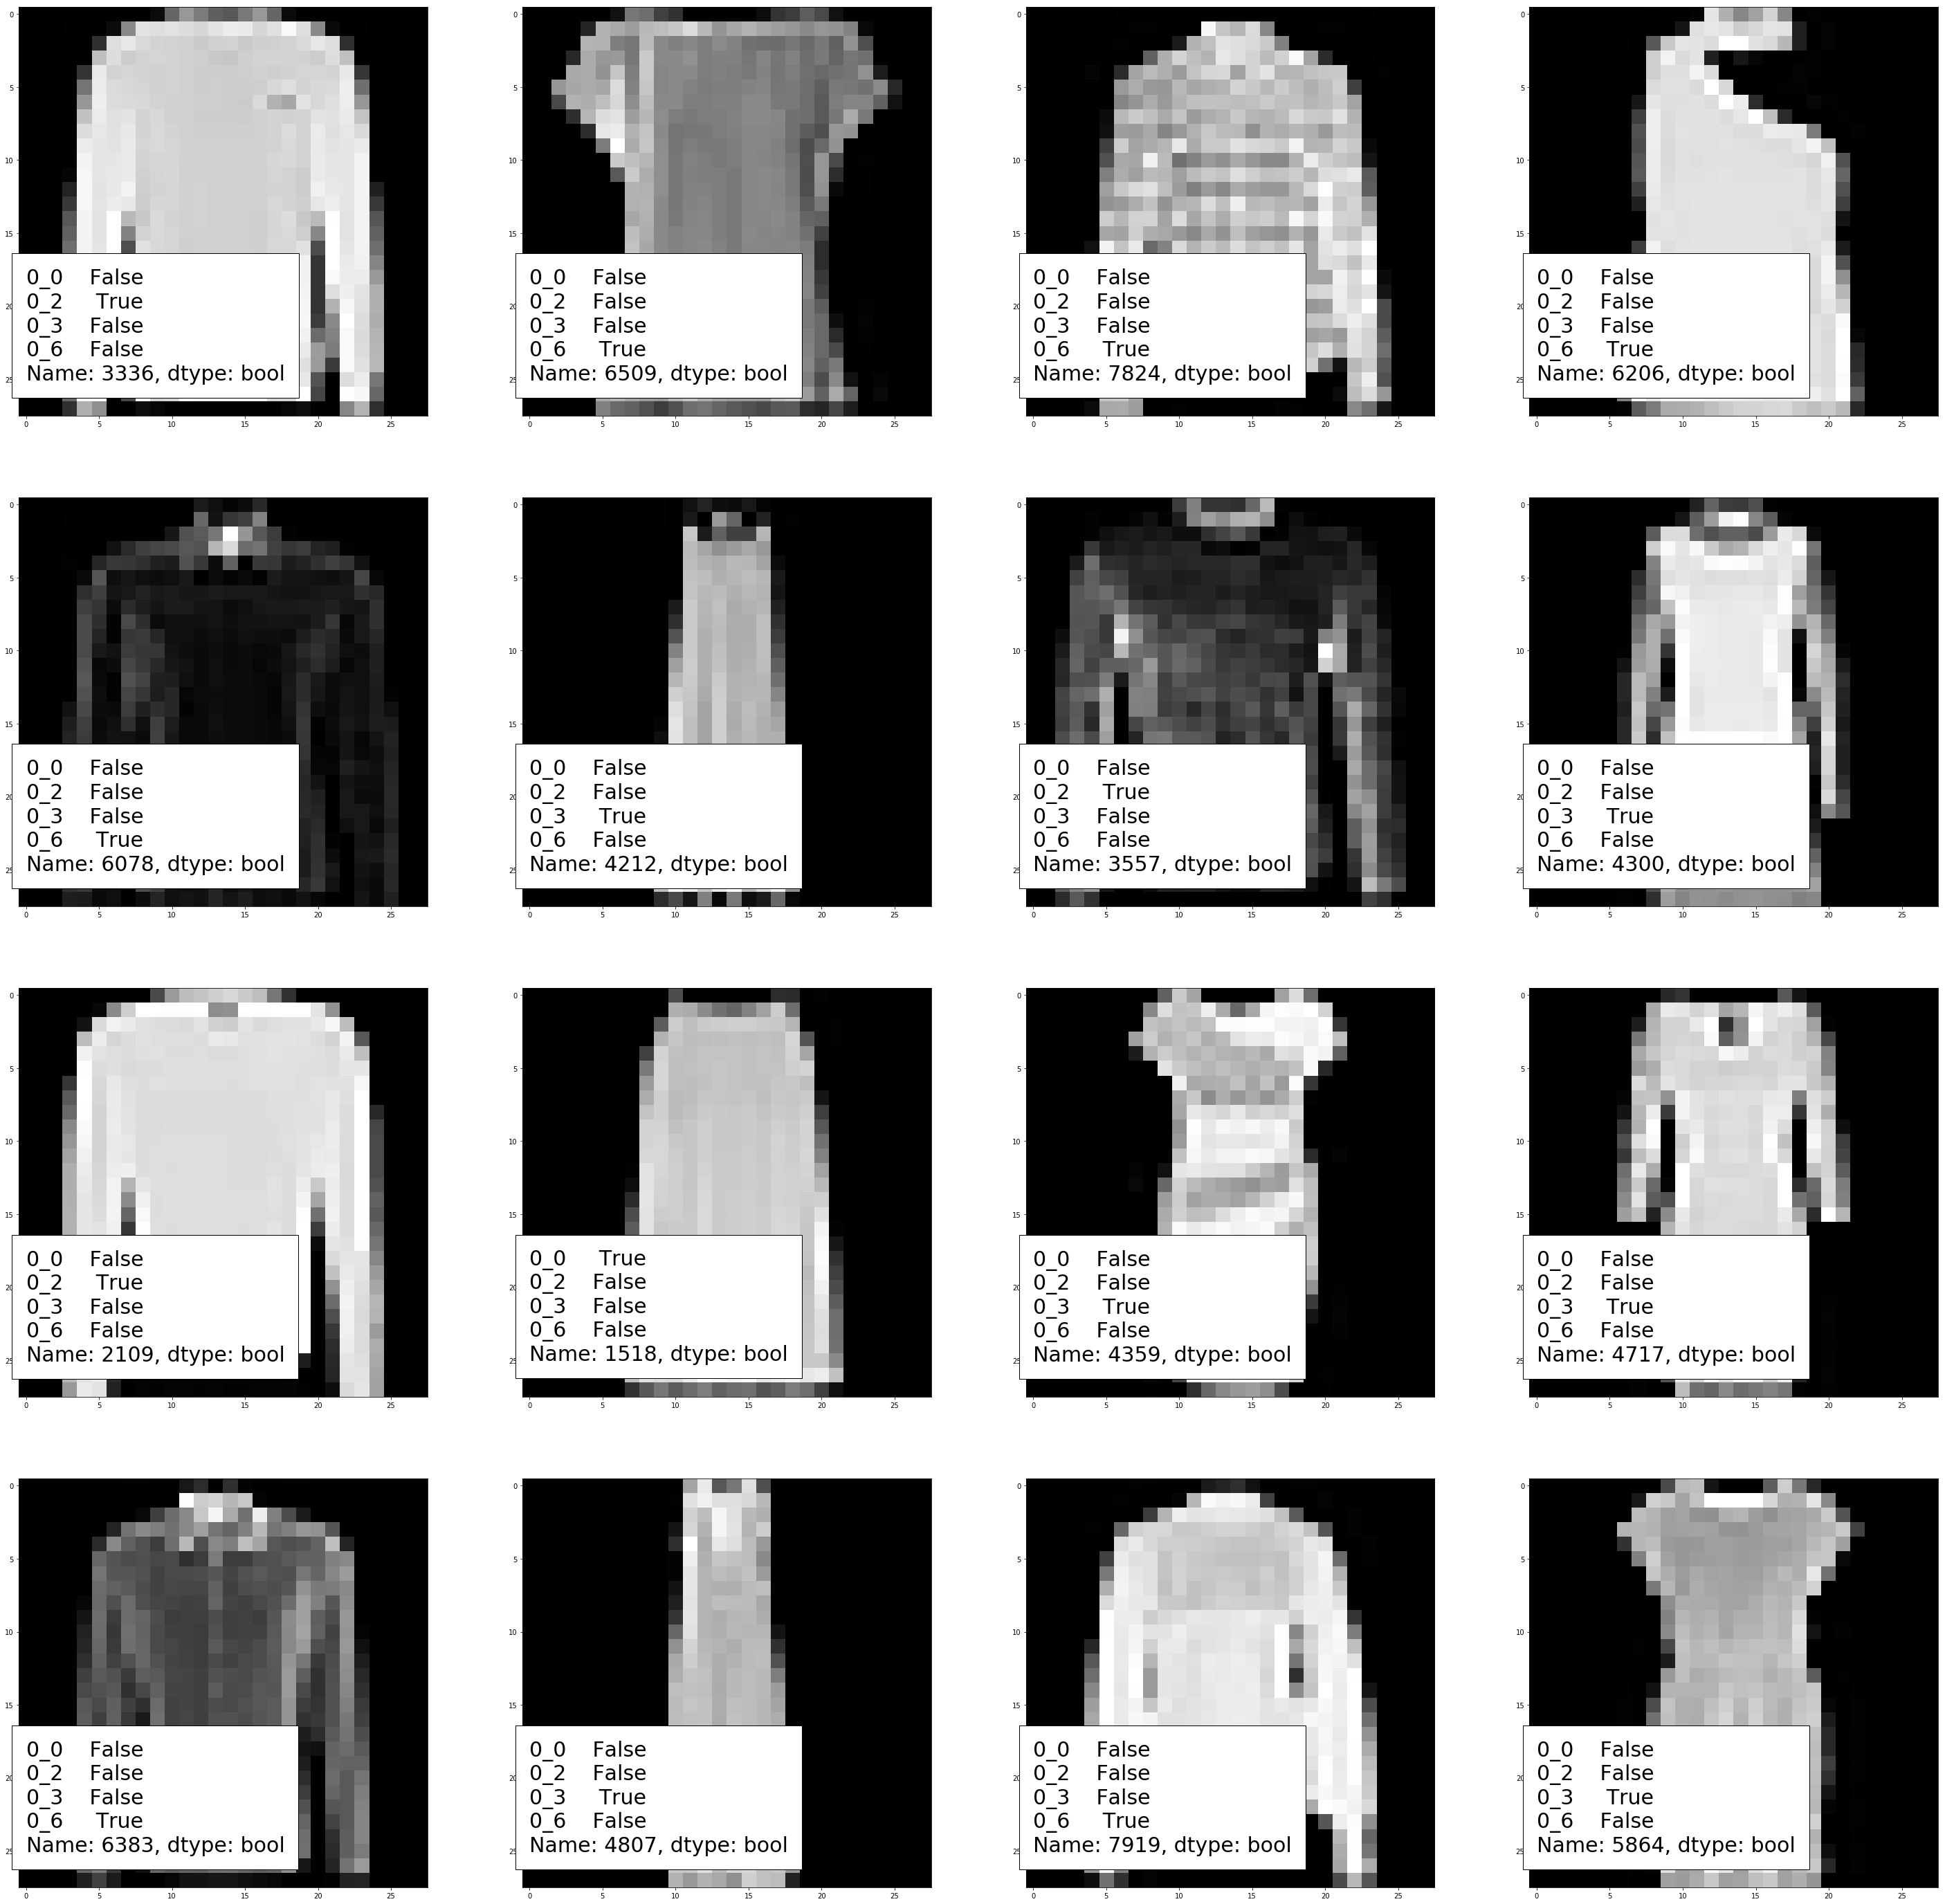

In [20]:
fig = plt.figure(figsize=(50, 50))
for i in range(16):
    sub = fig.add_subplot(4, 4, i + 1)
    sub.text(0, 25, str(y_train.iloc[i]==1), bbox={'facecolor': 'white', 'pad': 20}, fontsize=30)
    sub.imshow(np.reshape(x_train[i], (28, 28)), cmap='gray')

### Image Data Augmentation
> No usage of width shift and height shift during image augmentation as almost all the axes of the apparel in the image are centrally located vertically. For similar reasons, the apparel is not rotated.  

> Shearing not used as as all apparel are very similar to each other and shearing may cause one apparel to change to look like another, and since model is prone to overfitting due to less data, this is not feasible.  

> Only augmentations of rescaling and horizontal flip is done.

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

### ImageDataGenerator objects are fit to their corresponding datasets

In [22]:
train_datagen.fit(x_train)
valid_datagen.fit(x_valid)
test_datagen.fit(test)

### Implementing the neural network

> A series of 4 convolutional layers is implemented with one dense layer following it.  
> Output of convolutional layers are flattened and fed to dense network

> Dropout: Set considerably high compared to normal droupout rate to avoid overfitting as dataset is small.  

> Regularizers: Allow to apply penalties on layer parameters or layer activity during optimization. These penalties are incorporated in the loss function that the network optimizes. L2 regularizer has been selected as L2 is able to learn from complex patterns.  

> Average Pooling: Used as max pooling selected features common to all classes resulting in poor performance.  

> Output layer: 4 nodes for each class with Softmax as activation as softmax is able to distinguish between k classed given.  

> Optimizer: Adam is selected. Learning rate is reduced as minima loss was not decreasing for higher learning rate, possible problem of being stuck in local minima or divergence.  

> Epochs: 100 epochs with callback performed.

In [23]:
model = Model()

ip = Input(shape=(img_dim, img_dim, 1))

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', #64 filters
           kernel_regularizer=l2(0.01),)(ip)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', #64 filters
           kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = AvgPool2D(2, 2)(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', #128 filters
           kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = AvgPool2D(2, 2)(x)
x = Dropout(0.2)(x)

x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', #256 filters
           kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = AvgPool2D(2, 2)(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

op = Dense(4, activation='softmax')(x)

model = Model(inputs=ip, outputs=op)

In [24]:
model.compile(optimizer = Adam(lr=0.0005, decay=1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
__________

### Callback functions to be included
> EarlyStopping to stop training if validation loss does not decrease further for a certain number of epochs.  
> ModelCheckpoint used to record iteration of model with lowest validation loss.

In [26]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [27]:
model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, epochs=200,
                    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=len(x_valid)/batch_size, callbacks=callbacks)

Epoch 1/200
57/56 [==============================] - 5s 80ms/step - loss: 3.8186 - acc: 0.6572 - val_loss: 3.2393 - val_acc: 0.8063
Epoch 2/200
57/56 [==============================] - 2s 32ms/step - loss: 3.0427 - acc: 0.7490 - val_loss: 2.6575 - val_acc: 0.7963
Epoch 3/200
57/56 [==============================] - 2s 32ms/step - loss: 2.4634 - acc: 0.7874 - val_loss: 2.1430 - val_acc: 0.8187
Epoch 4/200
57/56 [==============================] - 2s 32ms/step - loss: 2.0190 - acc: 0.7996 - val_loss: 1.8529 - val_acc: 0.7812
Epoch 5/200
57/56 [==============================] - 2s 34ms/step - loss: 1.6802 - acc: 0.8102 - val_loss: 1.4907 - val_acc: 0.8313
Epoch 6/200
57/56 [==============================] - 2s 32ms/step - loss: 1.4136 - acc: 0.8263 - val_loss: 1.3258 - val_acc: 0.8100
Epoch 7/200
57/56 [==============================] - 2s 33ms/step - loss: 1.2025 - acc: 0.8400 - val_loss: 1.1186 - val_acc: 0.8375
Epoch 8/200
57/56 [==============================] - 2s 32ms/step - loss: 1.

### Loads weights of the model in which lowest validation loss was recorded by ModelCheckpoint

In [28]:
model.load_weights('best_model.h5')

### Validate model on validation dataset

In [29]:
pred = model.predict(x_valid)

In [30]:
pred = pd.DataFrame(pred)

### Count of positive prediction by model for each label
> Total of 200 positive predictions should be predicted ideally for each label

In [31]:
for i in range(4):
    print("No of predictions for " + str(i) + " is: " + str(pred[pred[i]>0.5].count()[0]))

No of predictions for 0 is: 183
No of predictions for 1 is: 216
No of predictions for 2 is: 195
No of predictions for 3 is: 206


In [32]:
pred.head(10)

,0,1,2,3
0,0.0,0.000000e+00,1.000000e+00,0.000000e+00
1,1.0,0.000000e+00,2.046556e-18,0.000000e+00
2,1.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0,1.000000e+00,0.000000e+00,8.070136e-20
4,0.0,0.000000e+00,1.000000e+00,0.000000e+00
5,0.0,0.000000e+00,0.000000e+00,1.000000e+00
6,0.0,0.000000e+00,0.000000e+00,1.000000e+00
7,0.0,2.084133e-21,0.000000e+00,1.000000e+00
8,0.0,1.000000e+00,0.000000e+00,0.000000e+00
9,0.0,0.000000e+00,0.000000e+00,1.000000e+00


In [33]:
y_valid.head(10)

,0_0,0_2,0_3,0_6
5676,0,0,1,0
617,1,0,0,0
415,1,0,0,0
7687,0,0,0,1
6708,0,0,0,1
6864,0,0,0,1
6664,0,0,0,1
6905,0,0,0,1
3390,0,1,0,0
6725,0,0,0,1


### Plotting confusion matrix for each label
> Each column of y_valid and column of pred are taken and confusion matrix is calculated  

> Individual accuracy score is calculated for each label

In [34]:
for i in range(4):
    print("\n")
    print("Confusion matrix for column " + str(i) + " is:")
    print(c_m(np.array(pred[i]).round(), np.array(y_valid.iloc[:, i])))
    print("Accuracy score for column " + str(i) + " is: " +
          str(a_s(np.array(pred[i]).round(), np.array(y_valid.iloc[:, i]))))
print("\n")



Confusion matrix for column 0 is:
[[582  35]
 [ 20 163]]
Accuracy score for column 0 is: 0.93125


Confusion matrix for column 1 is:
[[562  22]
 [ 35 181]]
Accuracy score for column 1 is: 0.92875


Confusion matrix for column 2 is:
[[584  21]
 [ 21 174]]
Accuracy score for column 2 is: 0.9475


Confusion matrix for column 3 is:
[[551  43]
 [ 45 161]]
Accuracy score for column 3 is: 0.89




### Predict labels of test dataset

In [35]:
pred = model.predict(test)

In [36]:
pred = pd.DataFrame(pred)

In [37]:
pred.columns = ['0', '2', '3', '6']

In [38]:
pred.sample(10)

,0,2,3,6
731,0.000000e+00,1.000000e+00,0.0,0.000000e+00
806,0.000000e+00,1.000000e+00,0.0,2.328861e-22
638,0.000000e+00,9.997134e-01,0.0,2.865698e-04
730,0.000000e+00,1.000000e+00,0.0,2.611244e-24
1200,0.000000e+00,0.000000e+00,1.0,0.000000e+00
1163,0.000000e+00,0.000000e+00,1.0,0.000000e+00
1411,4.374222e-34,1.267340e-36,1.0,1.369450e-26
962,0.000000e+00,1.000000e+00,0.0,3.772492e-30
1474,0.000000e+00,0.000000e+00,1.0,0.000000e+00
1843,4.990175e-06,2.797397e-11,0.0,9.999950e-01


### Convert indicator variable to categorical variable and save submission file

In [39]:
pred = pred.idxmax(axis=1)

In [40]:
pred.sample(10)

1918    6
1739    2
1329    3
1952    0
414     6
1755    6
325     0
691     2
98      6
727     2
dtype: object

In [41]:
pd.DataFrame(pred).to_csv('Vedang_Mandhana.csv')

In [6]:
pred = pd.read_csv('Vedang_Mandhana.csv', index_col=0)

In [7]:
pred.columns = ["image_index", "class"]

In [10]:
pd.DataFrame(pred).to_csv('Vedang_Mandhana.csv', index=0)